# Introduction to Data Science – Lecture 12 - APIs
Based on notes from *COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for **A**pplication **P**rogramming **I**nterface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs, REST (REpresentational State Transfer), which are now the dominant way of exposing and API on the web. REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this used to be
```
https://api.twitter.com/1.1/
```

A query would have looked like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests](https://requests.readthedocs.io/en/master/) library, which will handle our communication with the server.

In [59]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [60]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [61]:
response.content

b'{"iss_position": {"latitude": "50.6956", "longitude": "4.8831"}, "message": "success", "timestamp": 1717002934}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"iss_position": {"latitude": "10.6855", "longitude": "-62.8056"}, "timestamp": 1622223327, "message": "success"}


Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [36]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'iss_position': {'latitude': '10.6855', 'longitude': '-62.8056'}, 'timestamp': 1622223327, 'message': 'success'}


{'latitude': '10.6855', 'longitude': '-62.8056'}

Or, not surprisingly, pandas can also load a jsong object:

In [37]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,timestamp,message
latitude,10.6855,2021-05-28 17:35:27,success
longitude,-62.8056,2021-05-28 17:35:27,success


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_d["latitude"] = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del(response_d["iss_position"])
    return response_d
flatten(response_d)

{'timestamp': 1622223327,
 'message': 'success',
 'latitude': '10.6855',
 'longitude': '-62.8056'}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [38]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'message': 'success', 'timestamp': 1622652963, 'latitude': '30.4636', 'longitude': '-63.2818'}
{'message': 'success', 'timestamp': 1622652966, 'latitude': '30.5985', 'longitude': '-63.1318'}
{'message': 'success', 'timestamp': 1622652969, 'latitude': '30.7331', 'longitude': '-62.9814'}
{'message': 'success', 'timestamp': 1622652972, 'latitude': '30.8675', 'longitude': '-62.8305'}
{'message': 'success', 'timestamp': 1622652975, 'latitude': '31.0240', 'longitude': '-62.6539'}
{'message': 'success', 'timestamp': 1622652978, 'latitude': '31.1580', 'longitude': '-62.5019'}
{'message': 'success', 'timestamp': 1622652982, 'latitude': '31.3362', 'longitude': '-62.2987'}
{'message': 'success', 'timestamp': 1622652985, 'latitude': '31.4696', 'longitude': '-62.1458'}
{'message': 'success', 'timestamp': 1622652988, 'latitude': '31.6029', 'longitude': '-61.9923'}
{'message': 'success', 'timestamp': 1622652991, 'latitude': '31.7359', 'longitude': '-61.8383'}


10

Now we can convert this into a nice dataframe:

In [39]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)

Let's see how the ISS moves

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

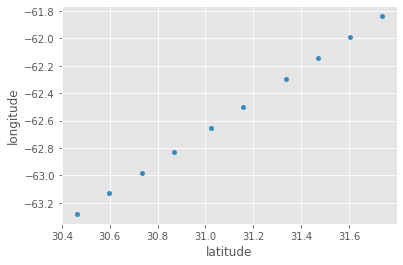

In [40]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [41]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1622653088,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 601, 'risetime': 1622663917},
  {'duration': 646, 'risetime': 1622669692},
  {'duration': 578, 'risetime': 1622675573},
  {'duration': 572, 'risetime': 1622681448},
  {'duration': 641, 'risetime': 1622687266}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2021-05-28 20:45:27')

So, the ISS will be visible at 4:13:34!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [42]:
r = requests.get("http://api.open-notify.org/astros.json")
data = r.json()
data

{'number': 7,
 'message': 'success',
 'people': [{'name': 'Mark Vande Hei', 'craft': 'ISS'},
  {'name': 'Oleg Novitskiy', 'craft': 'ISS'},
  {'name': 'Pyotr Dubrov', 'craft': 'ISS'},
  {'name': 'Thomas Pesquet', 'craft': 'ISS'},
  {'name': 'Megan McArthur', 'craft': 'ISS'},
  {'name': 'Shane Kimbrough', 'craft': 'ISS'},
  {'name': 'Akihiko Hoshide', 'craft': 'ISS'}]}

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 


We'll use the Github Python API wrapper: [PyGithub](https://github.com/PyGithub/PyGithub)

I also have used the commandline version fairly regularly (`brew install gh`).  I've used it to, for example, get a list of github usernames of everyone in an organization in JSON format, or to grant read access to a repo for each student in a course.  For getting data, the python API is probably nicer to use.


In [2]:
# imports for the python wrapper for the github API
# `pip3 install pygithub` then:

from github import Github
from github import Auth

You need to have permissions to access Github data.  Normally every HTTP request you send includes a `Authorization: Bearer-.....` header (or similar) with a "token" which Github can check to make sure you're allowed to request the info/perform the action you want.  In the "Developer Settings" menu of your settings page, you can create a "personal access token" which can be went wiht requests.  This works fine to get data using your own account.

If you were making an app for other people to use, typically you use a system like OAuth.  You register your app with Github and say which actions you want to perform on your users behalf.  When they run your app, they log into github and are asked if they approve of your app having permissions to perform some actions.  If the user agrees, they get a token which includes info about their own account as well as the app which is using it, and taht token is sent with requests.

In [10]:
# My token is in a file that I'm importing and not sharing with you all.
from githubAccessToken import github_token 

In [13]:
# Log in and get a "github object" which is the python wrapper for the REST API
auth = Auth.Token(github_token)
# First create a Github instance:
g = Github(auth=auth)

# method on g will make API calls to github and convert the reponses into python objects which are convenient to work with

In [22]:
display(g.get_user().name)
display(g.get_user().bio)

'Ben Jones'

'Teaching professor in the Kahlert School of Computing at U of Utah.  (see cs.utah.edu and msd.utah.edu).  Evangelist of the D language (dlang.org)'

In [58]:
repos = list(g.get_user().get_repos())
display(repos)

[Repository(full_name="benjones/acaTruth"),
 Repository(full_name="benjones/adaptiveDeformables"),
 Repository(full_name="benjones/adventOfCode2019"),
 Repository(full_name="benjones/arrayvl"),
 Repository(full_name="benjones/aStarAnimation"),
 Repository(full_name="benjones/autoparsed"),
 Repository(full_name="benjones/benjones.github.io"),
 Repository(full_name="benjones/benlib"),
 Repository(full_name="benjones/brokenThesis"),
 Repository(full_name="benjones/cppitertools"),
 Repository(full_name="benjones/dlang.org"),
 Repository(full_name="benjones/dmd"),
 Repository(full_name="benjones/druntime"),
 Repository(full_name="benjones/dtriangulate"),
 Repository(full_name="benjones/elastoplasticCuda"),
 Repository(full_name="benjones/eltopo"),
 Repository(full_name="benjones/farkle"),
 Repository(full_name="benjones/feedbackAggregator"),
 Repository(full_name="benjones/fem2D"),
 Repository(full_name="benjones/fluidSim"),
 Repository(full_name="benjones/fusepy"),
 Repository(full_name="b

The objects we get have nice methods for accessing properties of the relevant data.  Some of it was (probablly) included in the initial response, others (probably) require making additional requests to get that data

In [26]:
set( [repo.language for repo in repos])

{'C++',
 'D',
 'Go',
 'HTML',
 'Java',
 'JavaScript',
 'Jupyter Notebook',
 'Kotlin',
 'Makefile',
 None,
 'Python',
 'Rust',
 'Swift',
 'TeX'}

In [28]:
dRepos = [repo for repo in repos if repo.language == 'D']
display(dRepos)

[Repository(full_name="benjones/adventOfCode2019"),
 Repository(full_name="benjones/arrayvl"),
 Repository(full_name="benjones/autoparsed"),
 Repository(full_name="benjones/dmd"),
 Repository(full_name="benjones/druntime"),
 Repository(full_name="benjones/dtriangulate"),
 Repository(full_name="benjones/farkle"),
 Repository(full_name="benjones/phobos"),
 Repository(full_name="benjones/snappoll")]

Let's look at a particular repo in more detail

In [62]:
# advent of code is a yearly challenge with a new programming problem (christmas themed) each day of December until Christmas.
# I guess I did it in D in 2019
aoc2019 = dRepos[0]
aoc2019

Repository(full_name="benjones/adventOfCode2019")

I looked at 3 different sources of documentation for this example:

* The Python API lib docs
* the Github REST API docs [here](https://docs.github.com/en/rest/commits/commits?apiVersion=2022-11-28#get-a-commit) which I consider to probably be the most thorough/consistent
* introspecting the python objects themselves, like below

In [64]:
#dir(aoc2019) # tells me what members/methods this object has.  It's super useful!

In [31]:
aocCommits = list(aoc2019.get_commits())
aocCommits

[Commit(sha="030fac4ca763ec778b6e085d129d77b485c8a640"),
 Commit(sha="93728afb468f5ba2c1409ea6a46014bd622b91d7"),
 Commit(sha="54d5754a01c3601c896cbfcb45e36cd00df42666"),
 Commit(sha="671d44a0268e90e111d58dce15191c317c462a0b"),
 Commit(sha="11f7e51b3e856602d4e1567469ab4dc5e1b6045d"),
 Commit(sha="d4d0122bd330190d7158838f51c0a45bdf19a8c3"),
 Commit(sha="6a3545eb65eb12316e063da6c00f17a1072628b7"),
 Commit(sha="7e12efb0623d8f728e356a2363fec7b679afb939"),
 Commit(sha="ac89f5dffac3304ef019affc3dae8309da34919e"),
 Commit(sha="a48f3ccdbf7eeb1831e78901989ba8bcf18cef4b"),
 Commit(sha="9b4341970b388e4a6f003c2acfbac9aa2d9bd134"),
 Commit(sha="09a0150aa069e788f285f4f3482c062038e0c10c"),
 Commit(sha="1deb1a4be3dab8c5181c99845c5a0f232e02e359"),
 Commit(sha="bc50fde1921d5a40b8851185974f7f532cfc5640"),
 Commit(sha="429bc48544169fcbdb712e899e076bd954ff4ae1"),
 Commit(sha="1a062b28be4338c862a070e68264a3529d790655")]

In [43]:
# learned about commit.stats after the fact which will do this for the whole comit rather than by file...
def activity(file): return file.additions + file.changes + file.deletions

In [53]:
# aocCommits[0].commit.committer.date # use autocomplete to figure out what's in the API without looking at the docs constantly
# use a couple of list comprehensions here.  It's nice to work with these API reponses as python objects so I can just write python!

# commitData will have tuples of commit datetime and the total number of lines added/deleted/changed across all files in the commit

commitData = [(commit.commit.committer.date, sum([activity(x) for x in commit.files])) for commit in aocCommits]

OK, now let's do some data science.  We'll just see if we can learn about how hard the various day's challenges were.  We'll plot how much code I wrote/changed/deleted for each commit and that should give us a sense for relative difficulty

In [54]:
import pandas as pd
commitDF = pd.DataFrame(commitData, columns = ["date", "activity"]).set_index('date')

commitDF

,activity
date,
2019-12-27 19:19:07+00:00,2572
2019-12-24 17:57:07+00:00,386
2019-12-18 21:07:14+00:00,578
2019-12-18 17:47:46+00:00,580
2019-12-14 02:16:43+00:00,182
2019-12-12 17:21:28+00:00,280
2019-12-11 17:29:45+00:00,226
2019-12-10 17:13:51+00:00,308
2019-12-09 22:02:16+00:00,264


<Axes: xlabel='date'>

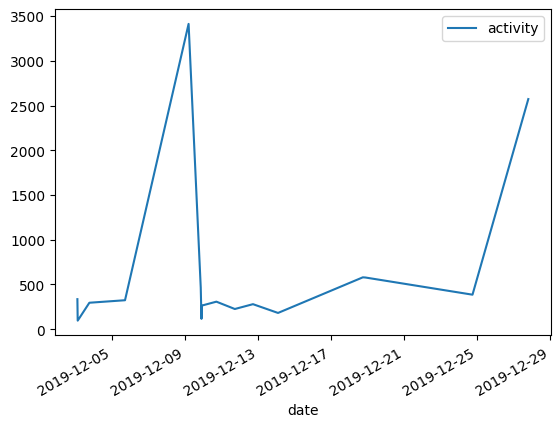

In [57]:
#Ta-da!!
commitDF.plot()